# EDA on AVIRIS CH4 Plume Estimates

## ER 131 Project | Group 4
**Author: ** ['Marshall Worsham'] <br>
**Date: ** 12-14-2020

## Front matter

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import re
import time
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
datadir = os.sep.join(['/Volumes', 'Brain', 'GIS', 'ER131', 'Project', 'Data'])
outdir = os.sep.join(['/Volumes', 'Brain', 'GIS', 'ER131', 'Project', 'Output'])

#### Import the AVIRIS CH$_4$ estimates

In [3]:
aviris_ch4_path = os.sep.join([outdir, 'AVIRIS_CH4_Estimates', 'AVIRIS_CH4.geojson'])
aviris_ch4_all = gpd.read_file(aviris_ch4_path)

In [4]:
print(aviris_ch4_all.shape)
aviris_ch4_all.head(5)

(234576, 15)


,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,geometry
0,33.884908,-117.069169,3A1 & 3A2 Enteric Fermentation and Manure Mana...,M & H Transport Inc,Dairy,DAF001764,2019-11-10,CA,MORENO VALLEY,RAFIQ,NaN,None,3346.0,NaN,"MULTIPOLYGON (((271213.628 -454741.620, 271212..."
1,35.468876,-119.315396,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001802,2019-11-10,CA,SHAFTER,RAFIQ,NaN,None,0.0,NaN,"MULTIPOLYGON (((62167.083 -282894.682, 62166.2..."
2,37.627947,-120.731059,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001834,2019-11-10,CA,HICKMAN,RAFIQ,NaN,None,NaN,NaN,"MULTIPOLYGON (((-64332.719 -42930.768, -64333...."
3,37.676834,-120.855524,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001835,2019-11-10,CA,Modesto,RAFIQ,NaN,None,0.0,NaN,"MULTIPOLYGON (((-75252.891 -37404.612, -75253...."
4,37.700263,-120.833078,3A1 & 3A2 Enteric Fermentation and Manure Mana...,Dairy Name Unknown,Dairy,DAF001836,2019-11-10,CA,OAKDALE,RAFIQ,NaN,None,0.0,NaN,"MULTIPOLYGON (((-73253.083 -34817.829, -73253...."


#### Exploratory data analysis
`aviris_ch4_all` is a dataframe of dimension [234576, 15]. This contains the information we need for our response variable. Let's take a look around.

The key observation in the dataset is `CH4_Mass_kg`. This will be our response variable, and as noted above, it represents a direct measure of the mass in kg of CH$_4$ above each facility that was emitting a CH$_4$ plume during the time of overflight. There are several thousand `NaN` values, so we'll remove those so that we're only working with facilities for which an emission estimate exists.

In [6]:
aviris_ch4_valid = aviris_ch4_all[aviris_ch4_all['CH4_Mass_kg'].notna()]

There are 16 unique emitter types represented in the dataset, below.

In [7]:
print(aviris_ch4_valid['Vista_SType'].unique())

['Dairy' 'Feed Lot' 'Natural Gas Station' 'Oil and Gas Well'
 'Composting Sites' 'Digester' 'Landfill'
 'Liquefied Natural Gas Fueling Station'
 'Compressed Natural Gas Fueling Station' 'Oil and Gas Facility Boundary'
 'Oil and Gas Field Boundary' 'Power Plant'
 'Natural Gas Processing Plants' 'Refinery' 'Natural Gas Storage Field'
 'Wastewater Treatment Plant']


As the histogram below shows, the mass observationsare skewed positively. The lowest CH$_4$ mass values occur factor-4 more frequently than the highest.

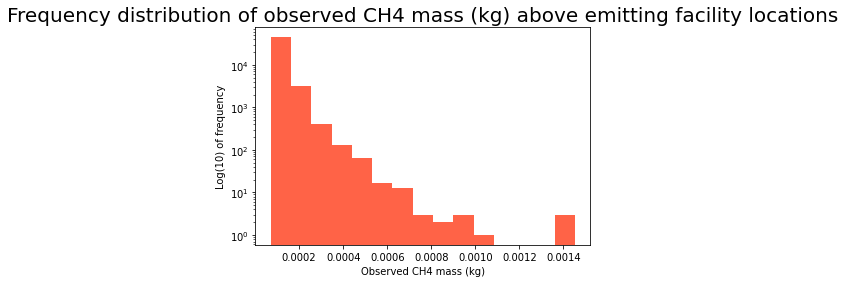

In [8]:
plt.hist(aviris_ch4_valid['CH4_Mass_kg'], bins = 15, color = 'tomato')
plt.yscale('log')
plt.title('Frequency distribution of observed CH4 mass (kg) above emitting facility locations', fontsize = 20)
plt.xlabel('Observed CH4 mass (kg)')
plt.ylabel('Log(10) of frequency');

We can see how balanced the dataset is by looking at the number of observations per emitter type. It's fairly unbalanced: on a log scale, oil and gas wells represent approximately 4.7x10$^4$ facilities, while the rest are on an order of magnitude of 10$^2$ and 10$^3$. However, when we consider mean emissions per facility, each oil and gas facility appears to emit around the same order of magnitude as other types.

In [ ]:
aviris_ch4_typecount = aviris_ch4_all.groupby('Vista_SType')['CH4_Mass_kg'].count()
aviris_ch4_kgsum = aviris_ch4_all.groupby('Vista_SType')['CH4_Mass_kg'].mean()

In [ ]:
ind = range(len(aviris_ch4_typecount))
width = np.min(np.diff(ind))/3.
names = list(aviris_ch4_typecount.index)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(ind-width/2., height = aviris_ch4_typecount, width = width, color = 'dimgrey', label = 'Count of facilities')
ax.bar(ind+width/2., height = aviris_ch4_kgsum, width = width, color = 'royalblue', label = 'Mean CH$_4$ (kg) per facility')
ax.axes.set_xticklabels(names)
plt.yscale('log')
plt.xticks(ind, rotation=90)
plt.title('Number of observations and mean CH4 (kg) per facility type', fontsize = 20)
plt.xlabel('Facility type')
plt.ylabel('Log(10) of number of facilities and mean CH$_4$ (kg) per facility type')
plt.legend();

Breaking the distribution of emission values down by emitter type, the medians are roughly on par. Digesters have the highest median emissions, and natural gas storage fields the lowest. Emissions from feed lots and dairies appear to vary widely, and feedlots, dairies, and wastewater treament plants to be rather positively skewed.

In [ ]:
#plt.figure(figsize=(25,10))
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.boxplot(x = aviris_ch4_valid['Vista_SType'], y = aviris_ch4_valid['CH4_Mass_kg'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Distribution of observed CH4 mass (kg) above 16 emitting facility types', fontsize=20)
plt.xlabel('Facility type')
plt.ylabel('CH4 Mass (kg) observed above facility location');

The primary concern that exploration of the AVIRIS CH$_4$ data raises is that of balance. With such a massive preponderance of observations from oil and gas wells, it's possible that the one-hot-coded `Oil and Gas Well` facility type predictor could have an exaggerated coefficient weight, and/or that the predictions for other categories of emitter are distorted by the big weight of a single emitter type.